<a href="https://colab.research.google.com/github/Camgamez/AlgorithmsUN2024II/blob/main/lab5/icgamezc_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantiacs Laboratory:

## Setup the Enviroment

The following cells are the setup for the quantiacs tools on Colab, these cells will not be moved to the quantiacs stratgy.

In [ ]:
###DEBUG###

! pip install git+https://github.com/quantiacs/toolbox.git 2>/dev/null

# decrease height
from IPython.display import Javascript
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'))

In [ ]:
###DEBUG###
import os

os.environ['API_KEY'] = "de356974-b758-445a-9891-d13b0524d442"
os.environ['NONINTERACT'] = 'True'

## The Strategy:

As per the lab's requirements, this part will be first tranining the model to process the information and also setting up a strategy that can help improvde the sharp ratio of the strategy.

Let's begin by importing all the necesary libraries:

In [ ]:
# This cell will import all the necesarry libraries for the data manipulation, AI training and technical analisis.

import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

NOTICE: The environment variable DATA_BASE_URL was not specified. The default value is 'https://data-api.quantiacs.io/'
NOTICE: The environment variable CACHE_RETENTION was not specified. The default value is '7'
NOTICE: The environment variable CACHE_DIR was not specified. The default value is 'data-cache'


Now let's load the data from the S&P500 market from July 1st 2005, we will not be choosing any specific asset, thus we are working with all the titles in the market:

In [ ]:
# loading S&P500 stock data
data = qndata.stocks.load_spx_data(min_date="2005-06-01")

| |#                                              | 15975 Elapsed Time: 0:00:00
| |#                                              | 15975 Elapsed Time: 0:00:00
| |         #                                   | 3224722 Elapsed Time: 0:00:00


fetched chunk 1/13 3s


| |         #                                   | 3293247 Elapsed Time: 0:00:00


fetched chunk 2/13 5s


| |         #                                   | 3203876 Elapsed Time: 0:00:00


fetched chunk 3/13 8s


| |         #                                   | 3076224 Elapsed Time: 0:00:00


fetched chunk 4/13 10s


| |         #                                   | 3280382 Elapsed Time: 0:00:00


fetched chunk 5/13 12s


| |         #                                   | 3356579 Elapsed Time: 0:00:00


fetched chunk 6/13 15s


| |         #                                   | 3384455 Elapsed Time: 0:00:00


fetched chunk 7/13 17s


| |         #                                   | 3346177 Elapsed Time: 0:00:00


fetched chunk 8/13 20s


| |          #                                  | 3439191 Elapsed Time: 0:00:01


fetched chunk 9/13 22s


| |         #                                   | 3421617 Elapsed Time: 0:00:00


fetched chunk 10/13 25s


| |          #                                  | 3520610 Elapsed Time: 0:00:01


fetched chunk 11/13 28s


| |          #                                  | 3705996 Elapsed Time: 0:00:01


fetched chunk 12/13 30s


| |       #                                     | 1900955 Elapsed Time: 0:00:00


fetched chunk 13/13 32s
Data loaded 33s


In the next block of code, we are building the learning strategy for the lab, using custom indicators:

In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """
    # Moving Avarages:
    close     = data.sel(field="close")
    sma_slow  = qnta.sma(close, 20)
    sma_fast  = qnta.sma(close, 5)
    weights   = xr.where(sma_slow < sma_fast, 1, -1)

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)

    # combine the features:
    result = xr.concat(
        [weights, trend, macd2_signal.sel(field="close"), volatility,  d, rsi, price],
        pd.Index(
            ["weight", "trend",  "macd", "volatility", "stochastic_d", "rsi", "price"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

Once the strategy has been created, we will display the table of all the assets per date:

In [ ]:
# displaying the features:
my_features = get_features(data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2005-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03,0.476186,0.090928,0.011079,-0.286286,-0.423893,-0.076676,-0.052508,-0.038536,-0.148813,-0.144848,...,0.131496,0.124510,-0.116372,0.194103,-0.284764,-0.244298,-0.225658,-0.038645,-0.090591,-0.269385
2025-01-06,0.570837,0.109125,-0.002609,-0.299095,-0.414204,-0.033469,-0.103898,-0.058897,-0.205249,-0.146438,...,0.076827,0.141274,-0.155560,0.156683,-0.261736,-0.241530,-0.227675,-0.117370,-0.119692,-0.213400
2025-01-07,0.583490,0.067688,-0.097462,-0.235601,-0.466720,-0.061832,-0.089889,-0.080209,-0.196211,-0.170126,...,0.055177,0.111899,-0.139843,0.146731,-0.307577,-0.205887,-0.247929,-0.154948,-0.132968,-0.251964


The following function (provided by the colab with the original streategy) identifies if the price of the required asset went up or down at the determined interval of time:

In [ ]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(data)
display(my_targetclass.to_pandas())

asset,NAS:AAL,NAS:AAPL,NAS:ABNB,NAS:ACGL,NAS:ADBE,NAS:ADI,NAS:ADP,NAS:ADSK,NAS:AEP,NAS:AKAM,...,NYS:WMB,NYS:WMT,NYS:WRB,NYS:WST,NYS:WY,NYS:XOM,NYS:XYL,NYS:YUM,NYS:ZBH,NYS:ZTS
time,,,,,,,,,,,,,,,,,,,,,
2005-06-01,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,1,0,1,1,0
2005-06-02,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2005-06-03,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
2005-06-06,0,0,0,0,0,0,0,1,0,1,...,0,1,1,1,1,0,0,1,1,0
2005-06-07,0,1,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03,1,1,0,0,1,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
2025-01-06,1,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2025-01-07,0,1,0,1,0,1,1,1,1,1,...,1,1,1,1,0,0,1,0,0,1


The next two cells define the function `get_model()` constructor for the kind of model to be utilized, in this case we will use a Stochastic Gradient Descend Model as this model works well with large datasets.

Then, the function `get_model()`is used to initiate and train our model

In [ ]:
def get_model():
    """This is a constructor for the ML model (Bayesian Ridge) which can be easily
       modified for using different models.
    """

    # model = linear_model.BayesianRidge()
    model = linear_model.SGDClassifier(loss="hinge", penalty="l2")
    return model

In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", how= "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", how= "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NAS:AAL': SGDClassifier(), 'NAS:AAPL': SGDClassifier(), 'NAS:ABNB': SGDClassifier(), 'NAS:ACGL': SGDClassifier(), 'NAS:ADBE': SGDClassifier(), 'NAS:ADI': SGDClassifier(), 'NAS:ADP': SGDClassifier(), 'NAS:ADSK': SGDClassifier(), 'NAS:AEP': SGDClassifier(), 'NAS:AKAM': SGDClassifier(), 'NAS:ALGN': SGDClassifier(), 'NAS:AMAT': SGDClassifier(), 'NAS:AMD': SGDClassifier(), 'NAS:AMGN': SGDClassifier(), 'NAS:AMZN': SGDClassifier(), 'NAS:ANSS': SGDClassifier(), 'NAS:APA': SGDClassifier(), 'NAS:AVGO': SGDClassifier(), 'NAS:AXON': SGDClassifier(), 'NAS:BIIB': SGDClassifier(), 'NAS:BKNG': SGDClassifier(), 'NAS:BKR': SGDClassifier(), 'NAS:CDNS': SGDClassifier(), 'NAS:CDW': SGDClassifier(), 'NAS:CEG': SGDClassifier(), 'NAS:CHRW': SGDClassifier(), 'NAS:CHTR': SGDClassifier(), 'NAS:CINF': SGDClassifier(), 'NAS:CMCSA': SGDClassifier(), 'NAS:CME': SGDClassifier(), 'NAS:COO': SGDClassifier(), 'NAS:COST': SGDClassifier(), 'NAS:CPB': SGDClassifier(), 'NAS:CPRT': SGDClassifier(), 'NAS:CRWD': SGDClassifie

Here we evaluate the importance of each of the features in the prediction of the training model:

[ 3.50623904  2.00267855 -9.72010612 -2.2548735  -1.38012834 -1.71559808
  1.37175428]
Feature: 0, Score: 3.50624
Feature: 1, Score: 2.00268
Feature: 2, Score: -9.72011
Feature: 3, Score: -2.25487
Feature: 4, Score: -1.38013
Feature: 5, Score: -1.71560
Feature: 6, Score: 1.37175


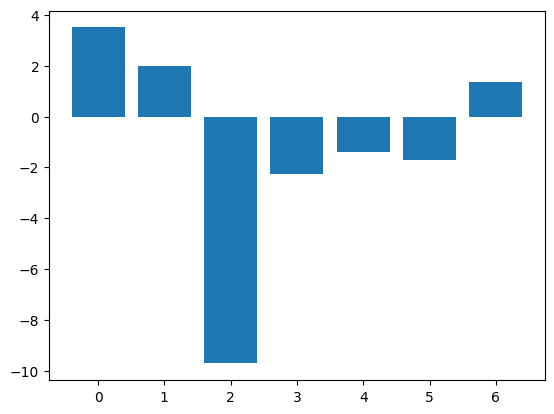

In [ ]:
# Showing which features are more important in predicting:

i = models['NAS:AAL'].coef_
importance = i[0]
print(importance)
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

Now, we choose those features that were evaluated less than 1 to generate the prediction and calculate the sharp ratio:

In [ ]:
# Performs prediction and generates output weights:

asset_name_all = data.coords["asset"].values
weights = xr.zeros_like(data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 4936, asset: 516)> Size: 20MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * time     (time) datetime64[ns] 39kB 2005-06-01 2005-06-02 ... 2025-01-10
    field    <U5 20B 'close'
  * asset    (asset) <U9 19kB 'NAS:AAL' 'NAS:AAPL' ... 'NYS:ZBH' 'NYS:ZTS'


In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights)
sharpe

0.6390186689420569

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-03,11.288474,0.008742,0.204578,-0.055635,-0.545879,0.644440,0.131838,1.0,425.0,0.068496,29.157286
2025-01-06,11.283436,-0.000446,0.204557,-0.056056,-0.545879,0.644240,0.131784,1.0,425.0,0.068496,29.153647
2025-01-07,11.239145,-0.003925,0.204539,-0.059762,-0.545879,0.643047,0.131528,1.0,425.0,0.068502,29.151511
2025-01-08,11.256600,0.001553,0.204518,-0.058301,-0.545879,0.643411,0.131589,1.0,425.0,0.068501,29.153806
2025-01-10,11.089375,-0.014856,0.204527,-0.072291,-0.545879,0.639019,0.130697,1.0,425.0,0.068503,29.670461


time,2025-01-10
field,
sharpe_ratio,0.639019


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'


WARNING! This strategy correlates with other strategies and will be rejected.
Modify the strategy to produce the different output.


The number of systems with a larger Sharpe ratio and correlation larger than 0.9: 1
The max correlation value (with systems with a larger Sharpe ratio): 0.9252673803831911
Current sharpe ratio(3y): 0.332876900893102

Correlated examples:

Name                                                  Coefficient    Sharpe ratio
--------------------------------------------------  -------------  --------------
Q18 Machine Learning on a Rolling Basis - disabled       0.925267        0.326534


In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

-0.9025498874382459

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

-0.13787827545674236

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.4509257252522207

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", how= "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", how= "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_s&p500",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-06-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?  #
)

Run the last iteration...
fetched chunk 1/2 0s
fetched chunk 2/2 0s
Data loaded 0s
fetched chunk 1/1 0s
Data loaded 0s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...
fetched chunk 1/2 0s
fetched chunk 2/2 0s
Data loaded 0s
---
Run all iterations...
Load data...
fetched chunk 1/15 0s
fetched chunk 2/15 0s
fetched chunk 3/15 0s
fetched chunk 4/15 0s
fetched chunk 5/15 0s
fetched chunk 6/15 0s
fetched chunk 7/15 1s
fetched chunk 8/15 1s
fetched chunk 9/15 1s
fetched chunk 10/15 1s
fetched chunk 11/15 1s
fetched chunk 12/15 1s
fetched chunk 13/15 1s
fetched chunk 14/15 1s
fetched chunk 15/15 1s
Data loaded 2s
fetched chunk 1/13 0s
fetched chunk 2/13 0s
fetched chunk 3/13 0s
fetched chunk 4/13 0s
fetched chunk 5/13 0s
fetched chunk 6/13 1s
fetched chunk 7/13 1s
fetched chunk 8/13 1s
fetched chunk 9/13 1s
fetched chunk 10/13 1s
fetched chunk 11/13 1s
fetched chunk 12/13 1s
fetched chunk 13/13 1s
Data loaded 2s
Backtest...
